# **S-PLM v2: Quickstart**

This notebook is a **usage example** of **S-PLM v2**.

* **Purpose:**

    1. Process PDB structures into the standardized inputs expected by our model.
    
    2. Generate **protein-level** and **residue-level** embeddings.
    
    3. Run sample evaluations and export metrics/logs.
* **Checkpoint:** An S-PLM v2 `.pth` checkpoint. Download from the provided [SharePoint link](https://mailmissouri-my.sharepoint.com/:u:/g/personal/wangdu_umsystem_edu/EUZ74fO3NOxHjTvc6uvKwDsB5fELaaw-oiPHFU9CJky_hg?e=4phwL0).



### **Environment Setup**

We **recommend** using an NVIDIA **A100** in Colab; other GPUs/CPU will work but may be slower or run into memory limits.


In [ ]:
# Clone S-PLM
!git clone -q https://github.com/Yichuan0712/SPLM-V2-GVP /content/SPLMv2

# Install minimal deps
!pip install 'git+https://github.com/facebookresearch/esm.git' -q
!pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup' -q
!pip install biopython -q

In [ ]:
!pip install -q "torch==2.5.0" "torchvision==0.20.0" "torchaudio==2.5.0" \
  --index-url https://download.pytorch.org/whl/cu121
import torch
TORCH = "2.5.0"
CUDA = "cu" + torch.version.cuda.replace(".", "")
whl_url = f"https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html"
print("Using wheel URL:", whl_url)
!pip install -q pyg_lib torch-scatter torch-sparse torch-cluster torch-spline-conv \
    -f {whl_url}
!pip install -q torch-geometric

### **Prepare Checkpoint**

1. **Download the model** from the provided **[SharePoint link](https://mailmissouri-my.sharepoint.com/:u:/g/personal/wangdu_umsystem_edu/EUZ74fO3NOxHjTvc6uvKwDsB5fELaaw-oiPHFU9CJky_hg?e=4phwL0)** to your local machine.
2. **Upload to your Colab runtime** (Files pane → Upload to session storage), then set:




In [3]:
CHECKPOINT_PATH = "/content/checkpoint_0280000_gvp.pth"

3. **Faster option (recommended):** Mount Google Drive and copy the checkpoint from Drive into the Colab runtime.


In [ ]:
from google.colab import drive, files
import os, shutil
drive.mount('/content/drive', force_remount=True)
shutil.copy("/content/drive/MyDrive/checkpoint_0280000_gvp.pth",
            "/content/checkpoint_0280000_gvp.pth")
CHECKPOINT_PATH = "/content/checkpoint_0280000_gvp.pth"

### **Generate Sequence Embeddings**

Use GVP model to generate embeddings from FASTA sequences, with optional truncation and residue-level outputs.

* **Standard run:** produces **protein-level** embeddings from `.fasta` to `.pkl`
* **Truncated run:** sets `--truncate_inference 1 --max_length_inference 1022` to handle long sequences

* **Residue-level run:** adds `--residue_level`

**Inputs:** `--input_seq` (FASTA), `--config_path`, `--checkpoint_path`.

**Outputs:** pickled embeddings in the working directory (per protein or per residue, depending on flags).


In [ ]:
import os
os.chdir('/content/SPLMv2')

# standard run
!python3 -m utils.generate_seq_embedding --input_seq /content/SPLMv2/dataset/protein.fasta \
  --config_path /content/SPLMv2/configs/config_plddtallweight_noseq_rotary_foldseek.yaml \
  --checkpoint_path /content/checkpoint_0280000_gvp.pth \
  --result_path ./

In [ ]:
import os
os.chdir('/content/SPLMv2')

# truncate_inference with max_length_inference=1022
!python3 -m utils.generate_seq_embedding --input_seq /content/SPLMv2/dataset/protein.fasta \
--config_path /content/SPLMv2/configs/config_plddtallweight_noseq_rotary_foldseek.yaml \
--checkpoint_path /content/checkpoint_0280000_gvp.pth \
--result_path ./ --out_file truncate_protein_embeddings.pkl \
--truncate_inference 1 --max_length_inference 1022

import pickle
with open('truncate_protein_embeddings.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
import os
os.chdir('/content/SPLMv2')

# residue_level representations
!python3 -m utils.generate_seq_embedding --input_seq /content/SPLMv2/dataset/protein.fasta \
--config_path /content/SPLMv2/configs/config_plddtallweight_noseq_rotary_foldseek.yaml \
--checkpoint_path /content/checkpoint_0280000_gvp.pth \
--result_path ./ --out_file truncate_protein_residue_embeddings.pkl \
--truncate_inference 1 --max_length_inference 1022 --residue_level

import pickle
with open('truncate_protein_residue_embeddings.pkl', 'rb') as f:
    data = pickle.load(f)

### **Preprocess PDB**

First preprocess your PDB files using the provided script; only the resulting HDF5 files can be fed into the S-PLM v2 GVP model.


In [8]:
!python /content/SPLMv2/data/preprocess_pdb.py --data /content/SPLMv2/dataset/CATH_4_3_0_non-rep_pdbs/ --save_path /content/CATH_4_3_0_non-rep_gvp/ --max_workers 4

/usr/local/lib/python3.12/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
Processing files: 100% 1553/1553 [00:08<00:00, 190.09it/s]
{'protein_complex': 0, 'no_chain_id_a': 457, 'h5_processed': 1530, 'single_amino_acid': 0, 'error': 0}


### **Generate Structure Embeddings**

Use GVP model to produce **residue-level structure embeddings** from **preprocessed HDF5** inputs and save them to `protein_struct_embeddings.pkl`, then quickly print the loaded result for inspection.

**Inputs:** `--hdf5_path` (preprocessed data), `--config_path`, `--checkpoint_path`.

**Output:** `protein_struct_embeddings.pkl` in the current directory (embeddings per protein/chain).

**Note:** You **must preprocess** PDB first, the model only accepts the processed HDF5 tensors.


In [ ]:
import os
os.chdir('/content/SPLMv2')
!python -m utils.generate_struct_embedding \
  --hdf5_path /content/CATH_4_3_0_non-rep_gvp/ \
  --config_path /content/SPLMv2/configs/config_plddtallweight_noseq_rotary_foldseek.yaml \
  --checkpoint_path /content/checkpoint_0280000_gvp.pth \
  --result_path ./ \
  --residue_level

import pickle
with open('protein_struct_embeddings.pkl', 'rb') as f:
    print(pickle.load(f))

### **Evaluate on CATH**

We use a CATH subset to assess the quality of structure embeddings on a clustering task, both through visualizations of the embedding space and through quantitative metrics such as silhouette scores and other clustering-based measures.

Build the GVP model structure model, run **CATH** evaluation with preprocessed HDF5 inputs, and save metrics/figures.
**Inputs:** `checkpoint_path`, `config_path`, and `cath_path` pointing to the CATH HDF5 directory `dataset/CATH_4_3_0_non-rep_h5/`.

**What it does:**

* Instantiates `StructRepresentModel` and sets `out_figure_path`.
* Calls `evaluate_with_cath_more_struct(...)` to compute clustering/quality metrics (Class/Architecture/Fold level, ARI, silhouette).
* Prints scores to stdout and writes a summary to `scores.txt` under `out_figure_path`.



In [ ]:
import os
os.chdir('/content/SPLMv2')
!git pull origin main

In [ ]:
# @title
import os
os.chdir('/content/SPLMv2')
!python cath_with_struct.py --checkpoint_path /content/checkpoint_0280000_gvp.pth \
--config_path /content/SPLMv2/configs/config_plddtallweight_noseq_rotary_foldseek.yaml \
--cath_path /content/SPLMv2/dataset/CATH_4_3_0_non-rep_h5/

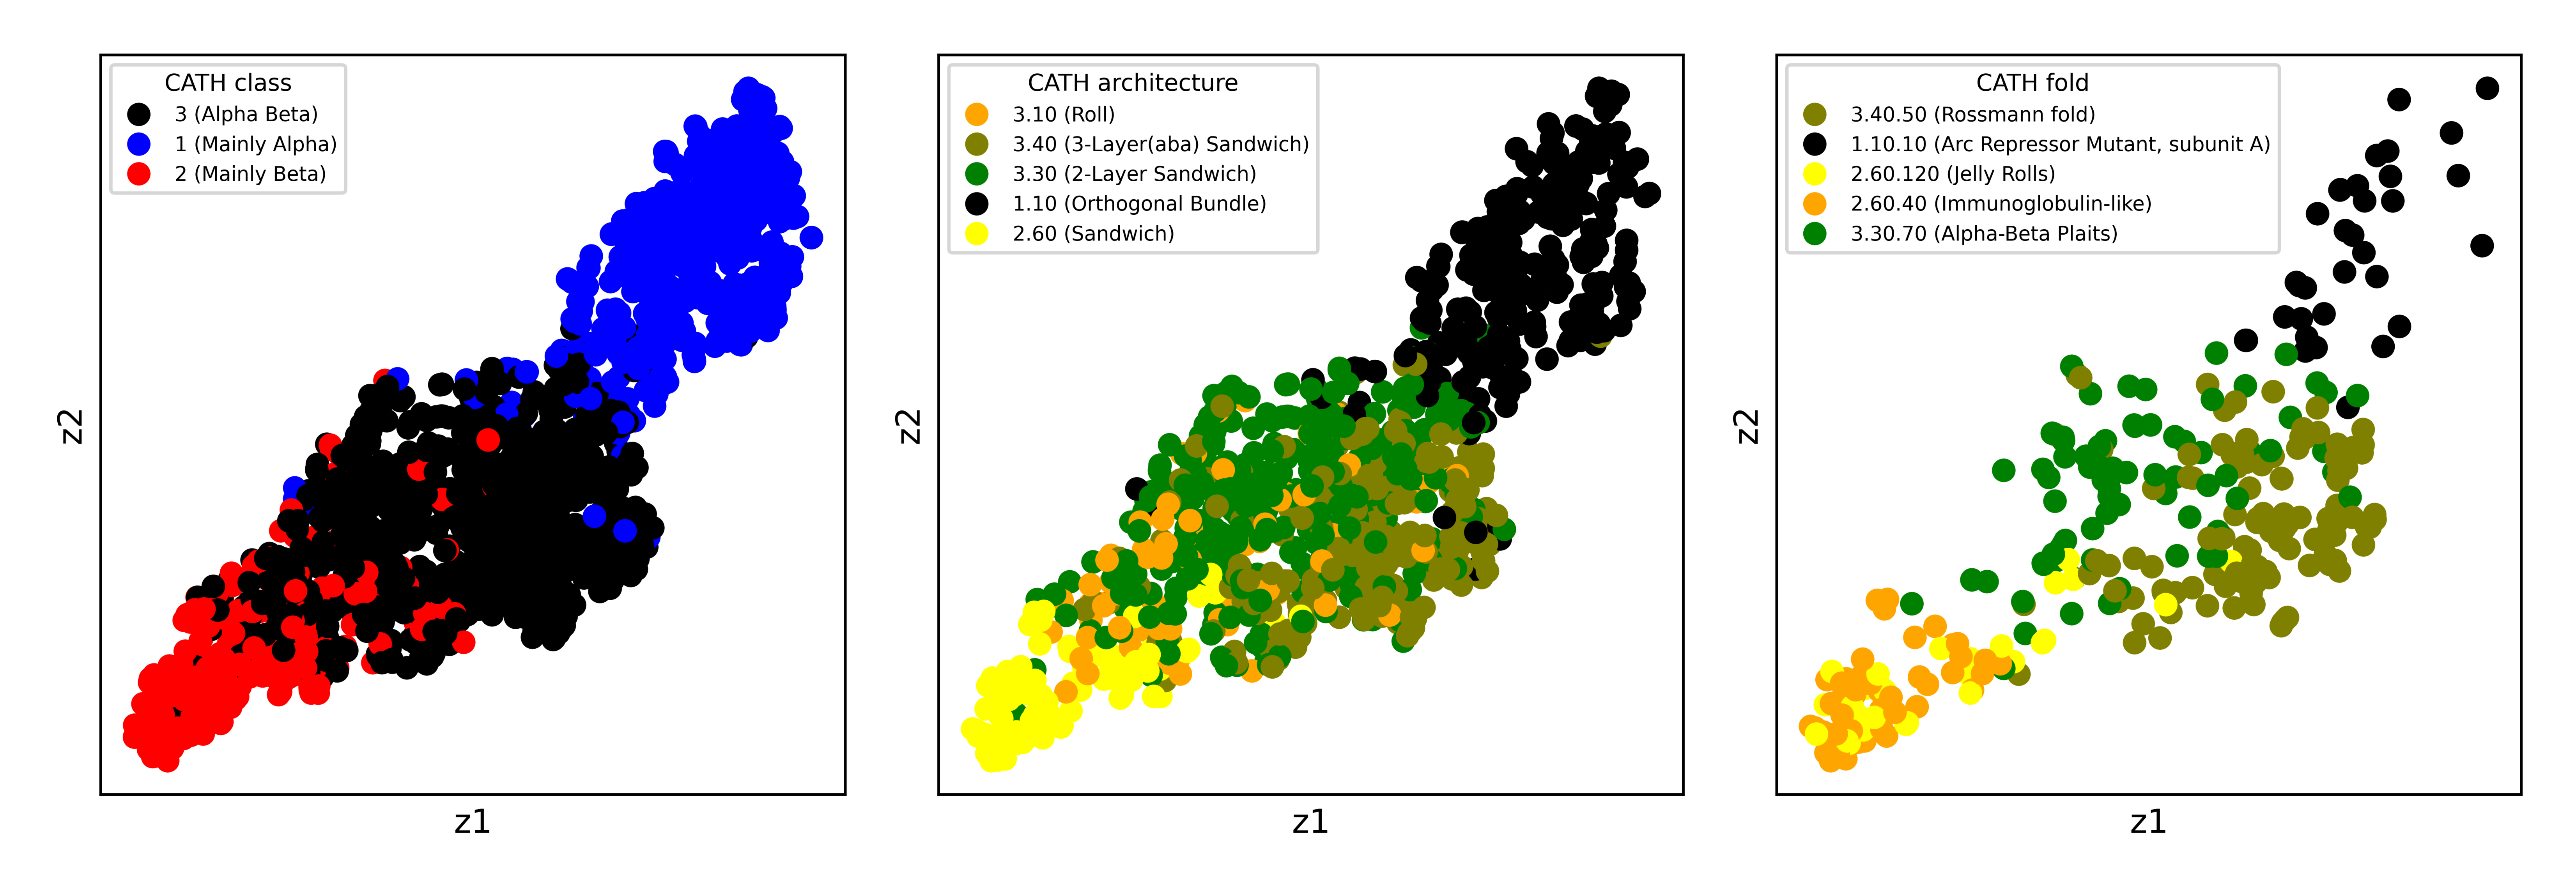

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

paths = [
    "/content/SPLMv2/configs/config_plddtallweight_noseq_rotary_foldseek/CATH_test_release/CATHgvp_1.png",
    "/content/SPLMv2/configs/config_plddtallweight_noseq_rotary_foldseek/CATH_test_release/CATHgvp_2.png",
    "/content/SPLMv2/configs/config_plddtallweight_noseq_rotary_foldseek/CATH_test_release/CATHgvp_3.png",
]

imgs = [Image.open(p) for p in paths]

total_width = sum(im.width for im in imgs)
max_height = max(im.height for im in imgs)

new_img = Image.new("RGB", (total_width, max_height), (255, 255, 255))
x = 0
for im in imgs:
    new_img.paste(im, (x, 0))
    x += im.width


dpi = 800
plt.figure(figsize=(total_width / dpi, max_height / dpi), dpi=dpi)
plt.imshow(new_img)
plt.axis("off")
plt.show()